In [1]:
from __future__ import division, print_function
# coding=utf-8
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from pprint import pprint

import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input as preprocess_input_vgg
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inc
from keras.models import Model, load_model
from keras import metrics

import tables
import nmslib

MODEL_PATH = 'models/inceptionv3_4_new_ohne_dpot_2.97270.hdf5'
hdf5_PATH = 'models/vgg16_bottleneck_features_IPCA.hdf5'
bin_PATH = 'models/image_features_pca_nmslib_index.bin'
model_inc = None
feat_extractor = None

hdf5_file = tables.open_file(hdf5_PATH, mode='r')
images = hdf5_file.root.img_paths

# nmslib default params for now
# Number of neighbors
K = 25
space_name='l2'
efS = 100
query_time_params = {'efSearch': efS}
index_ann = None

np.set_printoptions(threshold=np.nan) # prints the whole nparray no matter the shape of it

Using TensorFlow backend.


In [2]:
with open('meta/classes_230.txt', 'r') as textfile:
    categories = textfile.read().splitlines()

In [14]:
import pickle
pickle_in = open("models/sklearn_ipca_object.p","rb")
ipca = pickle.load(pickle_in)

In [77]:
def create_ann_index(bin_PATH, num_features):
    global index_ann
    # Intitialize the library, specify the space, the type of the vector and add data points 
    index_ann = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR) 
    index_ann.addDataPointBatch(features[:num_features])
    index_ann.createIndex(index_time_params, print_progress=True)
    # Setting query-time parameters and querying
    print('Setting query-time parameters', query_time_params)
    index_ann.setQueryTimeParams(query_time_params)

In [3]:
def init_ann_index(bin_PATH=bin_PATH):
    global index_ann
    # Intitialize the library, specify the space, the type of the vector and add data points 
    index_ann = nmslib.init(method='hnsw', space=space_name, data_type=nmslib.DataType.DENSE_VECTOR)
    # Re-load the index and re-run queries
    index_ann.loadIndex(bin_PATH)
    # Setting query-time parameters and querying
    print('Setting query-time parameters', query_time_params)
    index_ann.setQueryTimeParams(query_time_params)

In [ ]:
create_ann_index(bin_PATH, 400000)

In [4]:
init_ann_index()

Setting query-time parameters {'efSearch': 100}


In [5]:
def load_models(MODEL_PATH):
    global model_inc, feat_extractor
    model_inc = load_model(MODEL_PATH, custom_objects={'top_10_accuracy': top_10_accuracy})
    model_inc._make_predict_function()
    model_vgg = VGG16(weights='imagenet', include_top=True)
    #model_vgg = load_model(MODEL_VGG_PATH)
    feat_extractor = Model(inputs=model_vgg.input, outputs=model_vgg.get_layer("fc2").output)
    img, x = get_image_vgg("meta/kuchen.jpg")
    feat = feat_extractor.predict(x)
    print('Models loaded. Start serving...')

In [6]:
chefkoch_rezepte = pd.read_csv('meta/chefkoch.csv', index_col=False)

In [58]:
def top_10_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=10)

# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image_vgg(path):
    img = image.load_img(path, target_size=feat_extractor.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_vgg(x)
    return img, x
  
def get_image_inc(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_inc(x)
    return img, x
  
def plot_preds(image, probabilities, top_n):
    plt.imshow(image)
    plt.axis('off')
    plt.figure()
    
    order = list(reversed(range(top_n)))
    labels = [categories[x] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    bar_preds = [-np.sort(-probabilities)[i] for i, x in enumerate(np.argsort(-probabilities)[:top_n])]
    
    plt.barh(order, bar_preds, alpha=0.8, color='g')
    plt.title('the higher, the better', loc='center')
    plt.yticks(order, labels, color='g')
    plt.xlabel('Probability', color='g')
    plt.xlim(0, 1.01)
    plt.tight_layout()
    plt.show()
    
def plot_distances(distances, idx_closest):    
    order = list(range(len(distances)))[::-1] # just a list from 0 to K-1
    labels = [str(images[i]).split('/')[1] for i in idx_closest]
    
    plt.barh(order, distances, alpha=0.8, color='g')
    plt.title('the lower, the better', loc='center')
    plt.yticks(order, labels, color='g')
    plt.xlabel('L2 distance (euclidean)', color='g')
    plt.tight_layout()
    plt.show()

def show_result_images(final_result):
    rows = 5
    cols = 5
    fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(12, 12))
    fig.suptitle('Result Images from Query', fontsize=20)
    food_dirs = [food_direction[4] for food_direction in final_result]
    for i in range(rows):
        for j in range(cols):
            food_dir = food_dirs[i*cols + j]
            try:
                img = plt.imread('/Users/Muriz/Desktop/Extracting-food-preferences-master/notebooks/input/images/'+food_dir)
            except(FileNotFoundError):
                break
            ax[i][j].imshow(img)
            ec = (0, .6, .1)
            fc = (1, 1, 1)
            ax[i][j].text(0, 0, get_corresponding_recipes(final_result).recipe_name[i*cols + j], size=15, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def get_closest_images_nmslib(query_features, num_results=K):
    return index_ann.knnQuery(query_features, k = num_results)
    
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

def get_corresponding_recipes(final_results, chefkoch_rezepte=chefkoch_rezepte):
    chefkoch_rezepte_result = pd.DataFrame()
    for recipe_id_single in final_results:
        chefkoch_rezepte_result = chefkoch_rezepte_result.append(chefkoch_rezepte.query('recipe_id in @recipe_id_single[2]'), ignore_index=True)
    return chefkoch_rezepte_result

In [8]:
load_models(MODEL_PATH)

Models loaded. Start serving...


In [9]:
def weighting_neural_net_inputs(query_features, probabilities):
    """Combine outputs from Inceptionv3 and VGG-16 to a result list.
    
    Argument:
    query_features: query image fingerprint from VGG-16
    probabilities: Inception's category probabilities
    
    Return: final list containing category, inception's confidence,
            recipe id, image index and image path.
    """
    # do a query on image
    idx_closest, distances = get_closest_images_nmslib(query_features)
    
    #plot_distances(distances, idx_closest)
    
    # Don't forget to adjust string slicing for second hdf5
    # Labels only from ANN
    predicted_labels = [str(images[i]).split('/')[1] for i in idx_closest]
    
    # Results only from ANN
    predicted_ids = [[str(images[i]).split('-')[1], str(images[i]).split('-')[2].split('.')[0], 
                      images[i].decode("utf-8")] for i in idx_closest]
    
    pred_categories = []

    for i, x in enumerate(np.argsort(-probabilities)[:K]):
        confidence = -np.sort(-probabilities)[i]
        #print(categories[x], confidence)
        pred_categories.append([categories[x], confidence])
      
    predicted_labels_with_weights = []
    for iii in predicted_labels:
        for iiii, ii in enumerate(pred_categories):
            no_result = False
            if ii[0] == iii:
                predicted_labels_with_weights.append([iii, ii[1]])
                break
            if iiii == len(pred_categories)-1:
                predicted_labels_with_weights.append([iii, 0])
          
    predicted_labels_with_meta = [xi+yi for xi, yi in zip(predicted_labels_with_weights, predicted_ids)]
    final_result = sorted(predicted_labels_with_meta, key=lambda predicted_labels_with_meta: predicted_labels_with_meta[1], reverse=True)
    
    final_result_ann = [] # food result without weighting both nets, just ANN
    
    for i in predicted_ids:
        i.insert(0, 0)
        i.insert(0, 0)
        final_result_ann.append(i)
        
    return final_result

In [15]:
def model_predict(query_img_path):
    query_image, x = get_image_vgg(query_img_path)
    query_features = feat_extractor.predict(x)
    
    # project it into pca space
    pca_query_features = ipca.transform(query_features)[0]
  
    img, x = get_image_inc(query_img_path) # Preprocess query image for Inception
    probabilities = model_inc.predict(x)[0] # Get Inception's category probabilities not sorted
    plot_preds(img, probabilities, 15) # Plot Inception's category probabilities

    final_result = weighting_neural_net_inputs(pca_query_features, probabilities) # Get final food result
    
    #show_result_images(final_result_ann)
    show_result_images(final_result)
    return final_result

[[ 'category', incep_confidence, recipe_id, image_index, image_path ], [], ...]

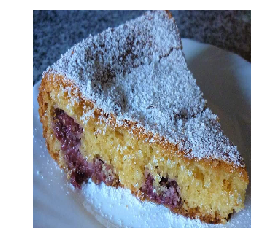

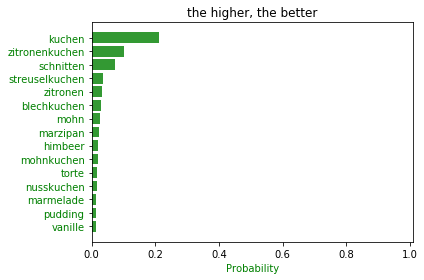

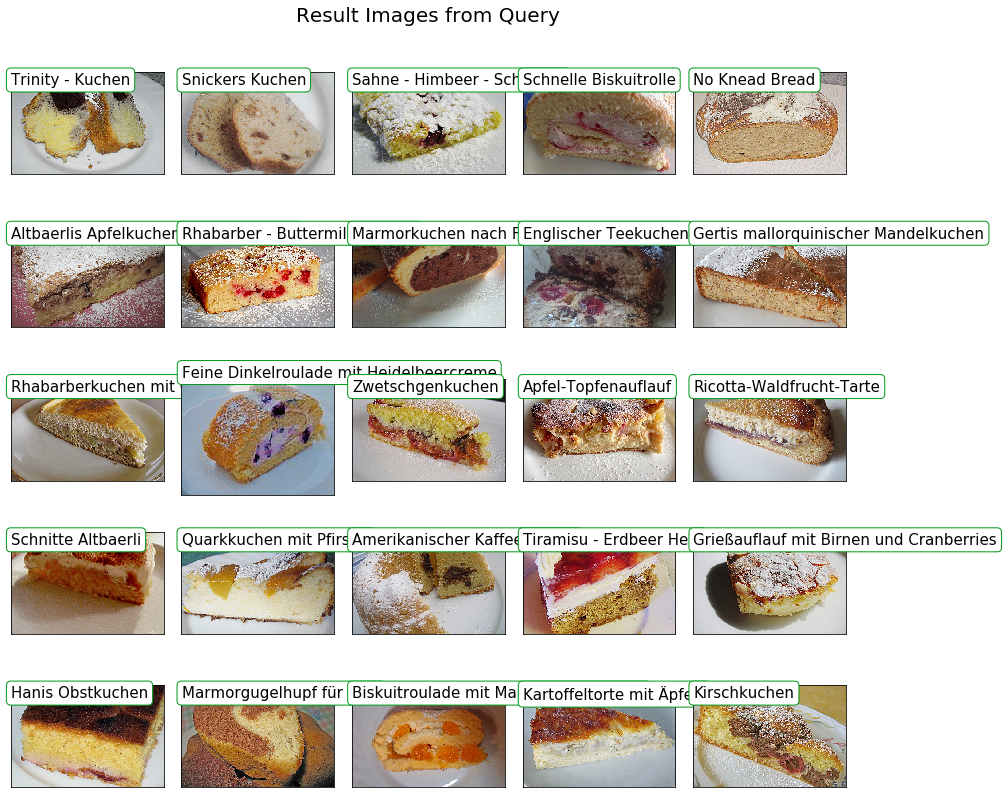

In [61]:
result_list = model_predict('uploads/24.jpg')
ids = [food_id[2] for food_id in result_list]
# For debugging purposes take online=False
# For production take online=True
#food = food_list_html(result_list=result_list[:7], online=False)

#pprint(result_list)

#chart = HTML(''.join(map(str, food)))
#display(chart)